# (1) Import

In [19]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

# (2) Block

### (2-1) FeatureMapBlock

In [20]:
class FeatureMapBlock(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(FeatureMapBlock, self).__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

  def forward(self, x):
    x = self.conv(x)
    return x

### (2-2) ContractingBlock

In [21]:
class ContractingBlock(nn.Module):
  def __init__(self, input_channels, use_bn=True, activation='relu', kernel_size=3):
    super(ContractingBlock, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1, stride=2)
    self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
    if use_bn:
      self.instancenorm = nn.InstanceNorm2d(input_channels*2)
    self.use_bn = use_bn

  def forward(self, x):
    x = self.conv1(x)
    if self.use_bn:
      x = self.instancenorm(x)
    x = self.activation(x)
    return x

### (2-3) ResidualBlock

In [22]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(input_channels*2, input_channels, kernel_size=3, padding=1)
    self.instancenorm = nn.InstanceNorm2d(input_channels)
    self.activation = nn.ReLU()
  
  def forward(self, x):
    original_x = x.clone()
    x = self.conv1(x)
    x = self.instancenorm(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.instancenorm(x)
    return original_x + x

### (2-4) ExpadingBlock

In [23]:
class ExpandingBlock(nn.Module):
  def __init__(self, input_channels, use_bn=True):
    super(ExpandingBlock, self).__init__()
    self.conv1 = nn.ConvTranspose2d(input_channels, input_channels//2, kernel_size=4, padding=1, stride=2)

    if use_bn:
      self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
    self.use_bn = use_bn
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    if self.use_bn:
      x = self.instancenorm(x)
    x = self.activation(x)
    return x

# (3) Generator

In [24]:
class Generator(nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels=64):
    super(Generator, self).__init__()
    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels)
    self.contract2 = ContractingBlock(hidden_channels*2)
    res_mult = 4
    self.res0 = ResidualBlock(hidden_channels*res_mult)
    self.res1 = ResidualBlock(hidden_channels*res_mult)
    self.res2 = ResidualBlock(hidden_channels*res_mult)
    self.res3 = ResidualBlock(hidden_channels*res_mult)
    self.res4 = ResidualBlock(hidden_channels*res_mult)
    self.res5 = ResidualBlock(hidden_channels*res_mult)
    self.res6 = ResidualBlock(hidden_channels*res_mult)
    self.res7 = ResidualBlock(hidden_channels*res_mult)
    self.res8 = ResidualBlock(hidden_channels*res_mult)
    self.expand2 = ExpandingBlock(hidden_channels*4)
    self.expand3 = ExpandingBlock(hidden_channels*2)
    self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
    self.tanh = torch.nn.Tanh()
  
  def forward(self, x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.res0(x2)
    x4 = self.res1(x3)
    x5 = self.res2(x4)
    x6 = self.res3(x5)
    x7 = self.res4(x6)
    x8 = self.res5(x7)
    x9 = self.res6(x8)
    x10 = self.res7(x9)
    x11 = self.res8(x10)
    x12 = self.expand2(x11)
    x13 = self.expand3(x12)
    xn = self.downfeature(x13)

    return self.tanh(xn)

# (4) Discriminator

In [25]:
class Discriminator(nn.Module):
  def __init__(self, input_channels, hidden_channels=64):
    super(Discriminator, self).__init__()
    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
    self.contract2 = ContractingBlock(hidden_channels*2, kernel_size=4, activation='lrelu')
    self.contract3 = ContractingBlock(hidden_channels*4, kernel_size=4, activation='lrelu')
    self.final = nn.Conv2d(hidden_channels*8, 1, kernel_size=1)

  def forward(self, x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    xn = self.final(x3)
    return xn

# (5) loss function

### (5-1) discriminator loss function

In [26]:
def get_disc_loss(real_x, fake_x, disc_x, adv_criterion):
  disc_fake_x_hat = disc_x(fake_x.detach())
  disc_fake_x_loss = adv_criterion(disc_fake_x_hat, torch.zeros_like(disc_fake_x_hat))
  disc_real_x_hat = disc_x(real_x.detach())
  disc_real_x_loss = adv_criterion(disc_real_x_hat, torch.ones_like(disc_real_x_hat))
  disc_loss = (disc_fake_x_loss + disc_real_x_loss) / 2

  return disc_loss

### (5-2) generator loss function

In [27]:
def get_gen_adversarial_loss(real_x, disc_y, gen_xy, adv_criterion):
  fake_y = gen_xy(real_x)
  disc_fake_y_hat = disc_y(fake_y)
  adversarial_loss = adv_criterion(disc_fake_y_hat, torch.ones_like(disc_fake_y_hat))

  return adversarial_loss, fake_y

### (5-3) cycle loss function

In [28]:
def get_cycle_consistency_loss(real_x, fake_y, gen_yx, cycle_criterion):
  cycle_x = gen_yx(fake_y)
  cycle_loss = cycle_criterion(real_x, cycle_x)

  return cycle_loss, cycle_x

### (5-4) identity loss function

In [29]:
def get_identity_loss(real_x, gen_yx, identity_criterion):
  identity_x = gen_yx(real_x)
  identity_loss = identity_criterion(real_x, identity_x)

  return identity_loss, identity_x

### (5-5) total loss function

In [30]:
def get_gen_loss(real_a, real_b, gen_ab, gen_ba, disc_a, disc_b, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
  adv_loss_ba, fake_a = get_gen_adversarial_loss(real_b, disc_a, gen_ba, adv_criterion)
  adv_loss_ab, fake_b = get_gen_adversarial_loss(real_a, disc_b, gen_ab, adv_criterion)
  gen_adversarial_loss = adv_loss_ba + adv_loss_ab

  identity_loss_a, identity_a = get_identity_loss(real_a, gen_ba, identity_criterion)
  identity_loss_b, identity_b = get_identity_loss(real_b, gen_ab, identity_criterion)
  gen_identity_loss = identity_loss_a + identity_loss_b

  cycle_loss_ba, cycle_a = get_cycle_consistency_loss(real_a, fake_b, gen_ba, cycle_criterion)
  cycle_loss_ab, cycle_b = get_cycle_consistency_loss(real_b, fake_a, gen_ab, cycle_criterion)
  gen_cycle_loss = cycle_loss_ba + cycle_loss_ab
  
  gen_loss = gen_adversarial_loss + lambda_identity*gen_identity_loss + lambda_cycle*gen_cycle_loss

  return gen_loss, fake_a, fake_b

# (6) ImageDataset

In [31]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self, root, transform=None, mode='train'):
    self.transform = transform
    self.files_a = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
    self.files_b = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
    if len(self.files_a) > len(self.files_b):
      self.files_a, self.files_b = self.files_b, self.files_a
    self.new_perm()
    assert len(self.files_a) > 0, "Make sure you downloaded the horse2zebra image"
  
  def new_perm(self):
    self.randperm = torch.randperm(len(self.files_b))[:len(self.files_a)]

  def __getitem__(self, index):
    item_a = self.transform(Image.open(self.files_a[index % len(self.files_a)]))
    item_b = self.transform(Image.open(self.files_b[self.randperm[index]]))
    if item_a.shape[0] != 3:
      item_a = item_a.repeat(3, 1, 1)
    if item_b.shape[0] != 3:
      item_b = item_b.repeat(3, 1, 1)
    if index == len(self) - 1:
      self.new_perm()
    return (item_a - 0.5) * 2, (item_b - 0.5) * 2

  def __len__(self):
    return min(len(self.files_a),len(self.files_b))

# (7) Parameters

In [32]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 1
dim_a = 3
dim_b = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda'

# (8) Data Loading

In [33]:
transform = transforms.Compose([
            transforms.Resize(load_shape),
            transforms.RandomCrop(target_shape),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("/content/drive/MyDrive/horse2zebra", transform=transform)

# (9) Generator, Discriminator 선언

In [34]:
gen_ab = Generator(dim_a, dim_b).to(device)
gen_ba = Generator(dim_b, dim_a).to(device)
gen_opt = torch.optim.Adam(list(gen_ab.parameters()) + list(gen_ba.parameters()), lr=lr, betas=(0.5, 0.999))
disc_a = Discriminator(dim_a).to(device)
disc_a_opt = torch.optim.Adam(disc_a.parameters(), lr=lr, betas=(0.5, 0.999))
disc_b = Discriminator(dim_b).to(device)
disc_b_opt = torch.optim.Adam(disc_b.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen_ab = gen_ab.apply(weights_init)
gen_ba = gen_ba.apply(weights_init)
disc_a = disc_a.apply(weights_init)
disc_b = disc_b.apply(weights_init)

# (10) Image display

In [35]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
  image_tensor = (image_tensor + 1) / 2
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

(11) train

Epoch 0: Step 0: Generator (U-Net) loss: 0.07562217712402344, Discriminator loss: 0.004018489122390747


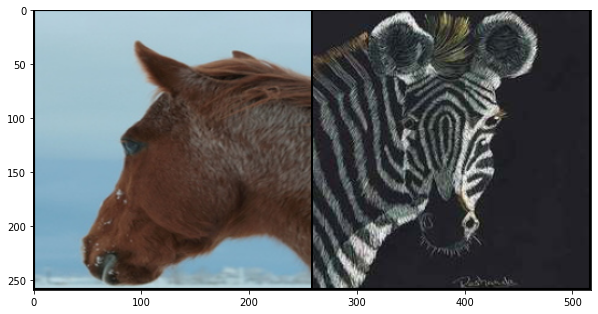

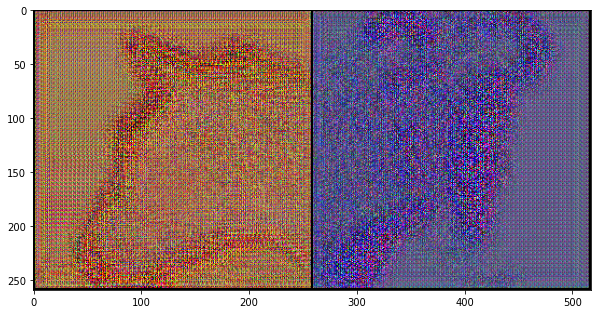

Epoch 0: Step 200: Generator (U-Net) loss: 6.806924910545346, Discriminator loss: 0.2687929330766202


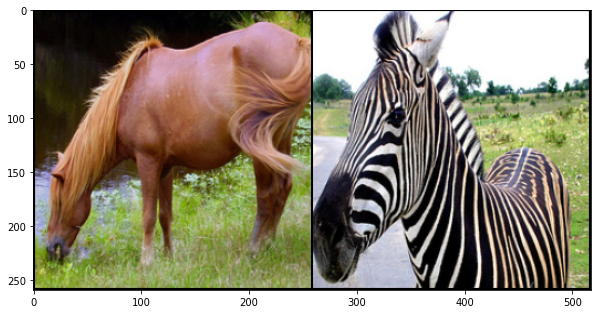

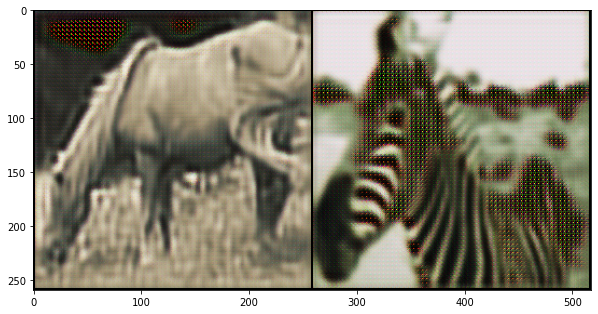

Epoch 0: Step 400: Generator (U-Net) loss: 5.843146582841872, Discriminator loss: 0.21081919036805624


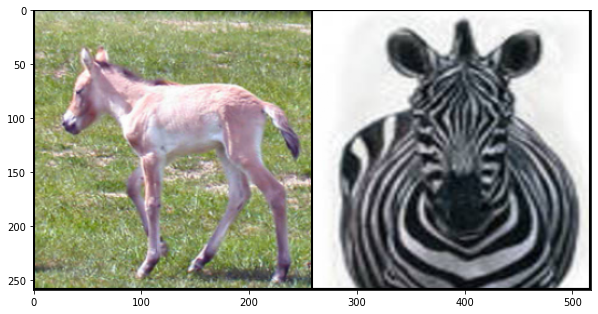

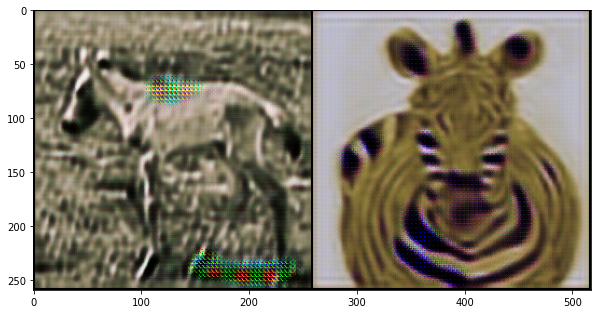

Epoch 0: Step 600: Generator (U-Net) loss: 5.413077546358111, Discriminator loss: 0.23223616749048237


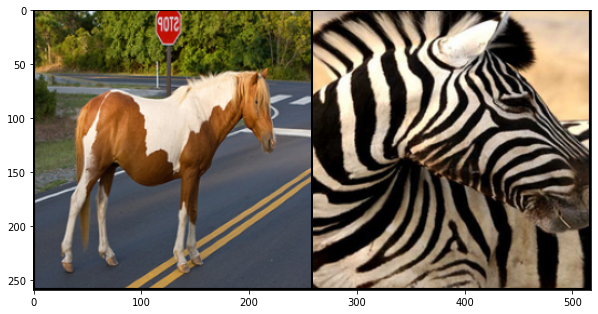

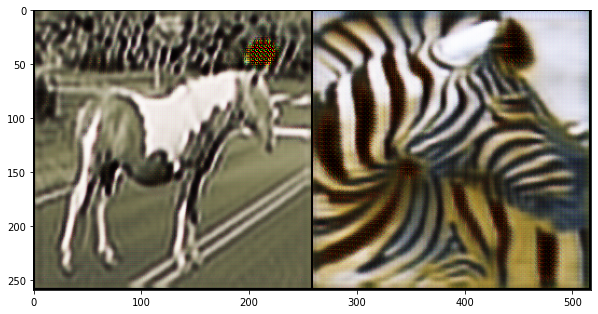

Epoch 0: Step 800: Generator (U-Net) loss: 5.272404462099074, Discriminator loss: 0.22547919690608978


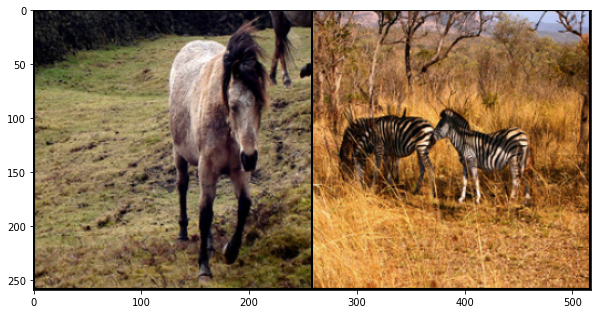

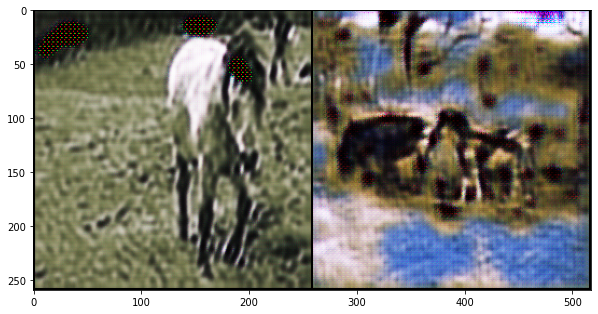

Epoch 0: Step 1000: Generator (U-Net) loss: 5.304424579143525, Discriminator loss: 0.23526842959225178


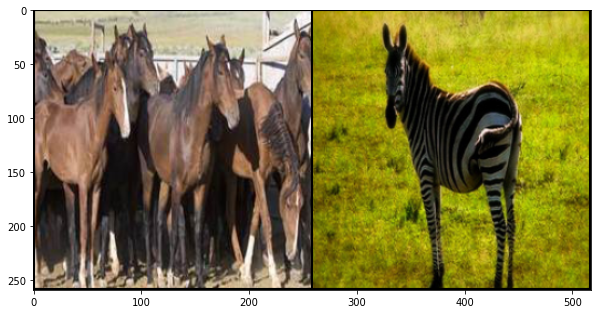

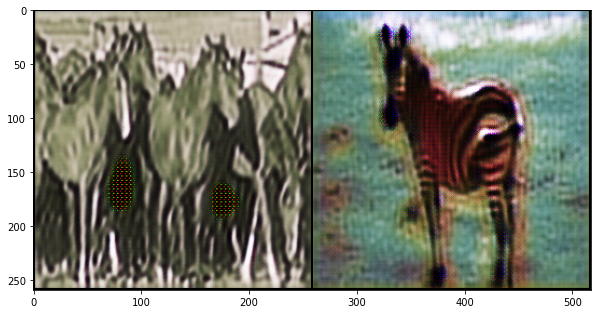

In [36]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)

def train(save_model=False):
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  cur_step = 0
  for epoch in range(n_epochs):
    for real_a, real_b in tqdm(dataloader):
      real_a = nn.functional.interpolate(real_a, size=target_shape)
      real_b = nn.functional.interpolate(real_b, size=target_shape)
      cur_batch_size = len(real_a)
      real_a = real_a.to(device)
      real_b = real_b.to(device)

      # Update discriminator A
      disc_a_opt.zero_grad()
      with torch.no_grad():
        fake_a = gen_ba(real_b)
      disc_a_loss = get_disc_loss(real_a, fake_a, disc_a, adv_criterion)
      disc_a_loss.backward(retain_graph=True)
      disc_a_opt.step()
      
      # Update discriminator B
      disc_b_opt.zero_grad()
      with torch.no_grad():
        fake_b = gen_ba(real_a)
      disc_b_loss = get_disc_loss(real_b, fake_b, disc_b, adv_criterion)
      disc_b_loss.backward(retain_graph=True)
      disc_b_opt.step()

      # Update generator
      gen_opt.zero_grad()
      gen_loss, fake_a, fake_b = get_gen_loss(real_a, real_b, gen_ab, gen_ba, disc_a, disc_b, adv_criterion, recon_criterion, recon_criterion)
      gen_loss.backward()
      gen_opt.step()

      mean_discriminator_loss += disc_a_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step

      if cur_step % display_step == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(torch.cat([real_a, real_b]), size=(dim_a, target_shape, target_shape))
        show_tensor_images(torch.cat([fake_b, fake_a]), size=(dim_b, target_shape, target_shape))
        mean_generator_loss = 0
        mean_discriminator_loss = 0

        if save_model:
          torch.save({
              'gen_ab': gen_ab.state_dict(),
              'gen_ba': gen_ba.state_dict(),
              'gen_opt': gen_opt.state_dict(),
              'disc_a': disc_a.state_dict(),
              'disc_a_opt': disc_a_opt.state_dict(),
              'disc_b': disc_b.state_dict(),
              'disc_b_opt': disc_b_opt.state_dict()
          }, f"/content/drive/MyDrive/horse2zebra/cycleGAN_{cur_step}.pth")
      cur_step += 1
train(save_model=True)